In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# we assume 5 colors per round for imaging constraints....
sns.set_context("notebook")
sns.set_style("darkgrid")
colors_per_round = 4


In [3]:
# with linear encoding of bits and combinatorial decoding of bits, the number of bits that we can decode as a function of rounds is a strict exponential increase.
# we probably also want to consider how many antibodies we use since this is actually pretty critical and determines the number of bits we can actually readily read out
def linear_encoding_combinatorial_decoding_bits_decoded(
    antibodies, colors_per_round, ceil=True
):
    """this modality assumes each GFP carries one scaffold, but we do a spot based readout that allows combinatorial decoding of bits."""
    unique_bits = antibodies
    # actually we can read out colors^num rounds = unique_codes
    # so the number of required rounds is log(colors^num rounds) = log(unique_codes) = num_rounds*log(colors_per_round)
    decoding_rounds = (
        np.ceil(np.log2(unique_bits) / np.log2(colors_per_round))
        if ceil
        else np.log2(unique_bits) / np.log2(colors_per_round)
    )
    return unique_bits, decoding_rounds


def combinatorial_encoding_linear_decoding_bits_decoded(
    antibodies, colors_per_round, ceil=True, floor=False
):
    """this modality assumes each GFP carries two tags, and we read"""
    set_length = np.floor(antibodies / 2) if floor else antibodies / 2
    unique_bits = np.square(set_length)
    decoding_rounds = (
        np.ceil(antibodies / colors_per_round)
        if ceil
        else antibodies / colors_per_round
    )
    return unique_bits, decoding_rounds


def linear_encoding_linear_decoding_bits_decoded(
    antibodies, colors_per_round, ceil=True
):
    unique_bits = antibodies
    decoding_rounds = (
        np.ceil(antibodies / colors_per_round)
        if ceil
        else antibodies / colors_per_round
    )
    return unique_bits, decoding_rounds


# define a function for combinatorial encoding and decoding of bits
def combinatorial_encoding_and_decoding_bits_decoded(
    antibodies, colors_per_round, ceil=True, floor=False
):
    set_length = np.floor(antibodies / 2) if floor else antibodies / 2
    unique_bits = np.square(set_length)
    decoding_rounds = (
        np.ceil(antibodies / colors_per_round)
        if ceil
        else antibodies / colors_per_round
    )
    return unique_bits, decoding_rounds


In [4]:
sns.color_palette("colorblind", 4)[0]

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)

In [5]:
# for a range of values of antibodies, plot the number of bits decoded as a function of rounds for both encoding schemes.
antibodies = np.arange(1, 29, 1)
linear_bits, linear_rounds = linear_encoding_combinatorial_decoding_bits_decoded(
    antibodies, colors_per_round
)
combinatorial_bits, combinatorial_rounds = (
    combinatorial_encoding_linear_decoding_bits_decoded(antibodies, colors_per_round)
)
standard_bits, standard_rounds = linear_encoding_linear_decoding_bits_decoded(
    antibodies, colors_per_round
)

combinatorial_encoding_and_decoding_bits_decoded(antibodies, colors_per_round)
df = pd.DataFrame(
    {
        "bits": linear_bits,
        "rounds": linear_rounds,
        "antibody_count": antibodies,
        "type": "Linear encoding, combinatorial decoding",
    }
)
df = df.append(
    pd.DataFrame(
        {
            "bits": combinatorial_bits,
            "rounds": combinatorial_rounds,
            "antibody_count": antibodies,
            "type": "Combinatorial encoding, linear decoding",
        }
    ),
    ignore_index=True,
)
df = df.append(
    pd.DataFrame(
        {
            "bits": standard_bits,
            "rounds": standard_rounds,
            "antibody_count": antibodies,
            "type": "Standard encoding/decoding",
        }
    ),
    ignore_index=True,
)

df["rounds"] = df["rounds"].astype(int)
df = (
    df.groupby(["type", "rounds"]).max().reset_index()
)  # simplified to get the max number before we'd need another round of imaging

palette = sns.color_palette("colorblind", 3)

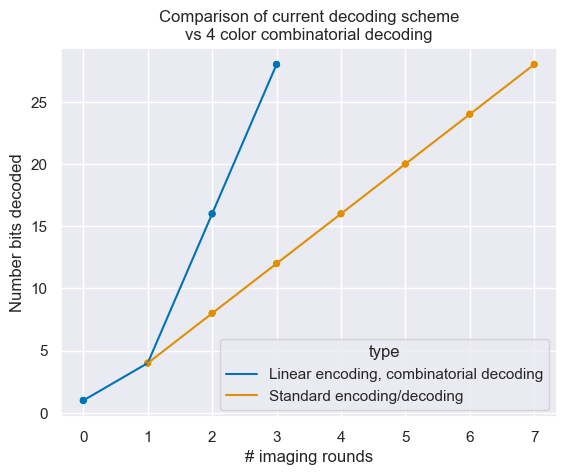

In [119]:
query = df["type"].isin(
    ["Linear encoding, combinatorial decoding", "Standard encoding/decoding"]
)

ax = sns.scatterplot(
    df[query],
    y="bits",
    x="rounds",
    hue="type",
    legend=False,
    palette=[palette[0], palette[1]],
)

ax = sns.lineplot(
    df[query], y="bits", x="rounds", hue="type", ax=ax, palette=[palette[0], palette[1]]
)


ax.set_xlabel("# imaging rounds")
ax.set_ylabel("Number bits decoded")
plt.title("Comparison of current decoding scheme\nvs 4 color combinatorial decoding")

plt.show()
# plt.legend()
# plt.ylabel("Number of Rounds")
# plt.xlabel("Number of Unique Bits Decoded")

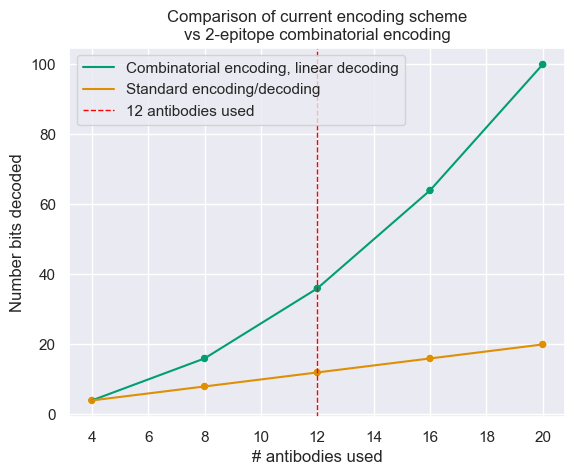

In [118]:
query = (
    df["type"].isin(
        ["Combinatorial encoding, linear decoding", "Standard encoding/decoding"]
    )
) & (df["antibody_count"] <= 20)

ax = sns.scatterplot(
    df[query],
    y="bits",
    x="antibody_count",
    hue="type",
    legend=False,
    palette=[palette[2], palette[1]],
)


ax = sns.lineplot(
    df[query],
    y="bits",
    x="antibody_count",
    hue="type",
    ax=ax,
    palette=[palette[2], palette[1]],
)


ax.set_xlabel("# antibodies used")
ax.set_ylabel("Number bits decoded")

# ax.vlines(x=12)
plt.title("Comparison of current encoding scheme\nvs 2-epitope combinatorial encoding")
plt.axvline(x=12, color="red", linestyle="--", linewidth=1, label="12 antibodies used")
plt.legend()


plt.show()


# plt.legend()
# plt.ylabel("Number of Rounds")
# plt.xlabel("Number of Unique Bits Decoded")

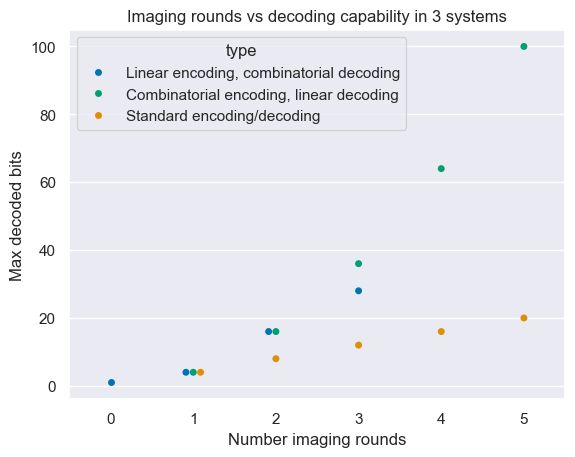

In [117]:
query = df["rounds"] <= 5

ax = sns.swarmplot(
    df[query],
    y="bits",
    x="rounds",
    hue="type",
    legend=True,
    palette=[palette[0], palette[2], palette[1]],
)
# ax = sns.lineplot(df[query], y = 'bits', x = 'rounds', hue = 'type', ax = ax,
#                   palette = [palette[0], palette[2], palette[1]])

ax.set_xlabel("Number imaging rounds")
ax.set_ylabel("Max decoded bits")

plt.title("Imaging rounds vs decoding capability in 3 systems")

plt.show()

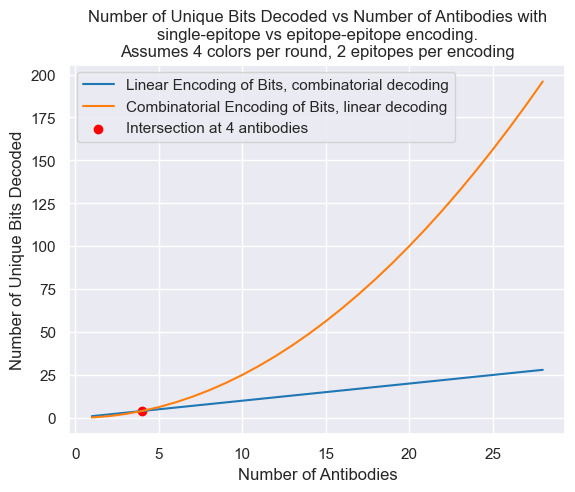

In [4]:
# make these as 3 separate plots
# plt.figure(figsize = (10, 10))
plt.plot(
    antibodies, linear_bits, label="Linear Encoding of Bits, combinatorial decoding"
)
plt.plot(
    antibodies,
    combinatorial_bits,
    label="Combinatorial Encoding of Bits, linear decoding",
)
# plt.plot(antibodies, standard_bits, label = "Current encoding/decoding")

plt.xlabel("Number of Antibodies")
plt.ylabel("Number of Unique Bits Decoded")
# plt.yscale("log")


# plt.yscale("log")
# calculate the intersection of the two curves
intersection = np.where(linear_bits == combinatorial_bits)
plt.scatter(
    antibodies[intersection],
    linear_bits[intersection],
    color="red",
    label=f"Intersection at {antibodies[intersection].item()} antibodies",
)
plt.legend()
plt.title(
    f"Number of Unique Bits Decoded vs Number of Antibodies with\nsingle-epitope vs epitope-epitope encoding.\nAssumes {colors_per_round} colors per round, 2 epitopes per encoding"
)
plt.show()

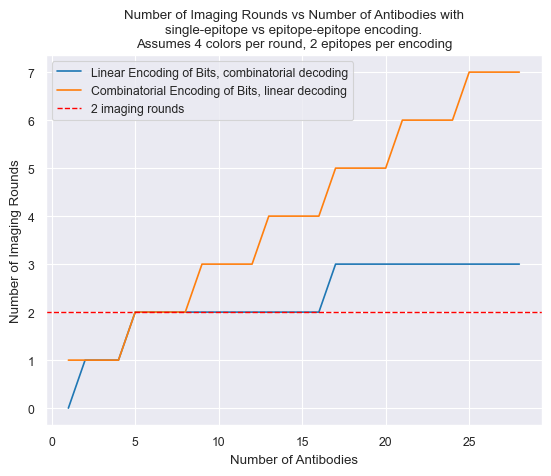

In [46]:
# plot the number of imaging rounds required for each encoding scheme
plt.plot(
    antibodies, linear_rounds, label="Linear Encoding of Bits, combinatorial decoding"
)
plt.plot(
    antibodies,
    combinatorial_rounds,
    label="Combinatorial Encoding of Bits, linear decoding",
)
# plt.plot(antibodies, standard_rounds, label = "Current encoding/decoding", color = "blue", linestyle = "-", linewidth = 2)
plt.xlabel("Number of Antibodies")
plt.ylabel("Number of Imaging Rounds")

plt.axhline(y=2, color="red", linestyle="--", linewidth=1, label="2 imaging rounds")
plt.legend()
plt.title(
    f"Number of Imaging Rounds vs Number of Antibodies with\nsingle-epitope vs epitope-epitope encoding.\nAssumes {colors_per_round} colors per round, 2 epitopes per encoding"
)
plt.show()


In [47]:
df = pd.DataFrame(
    {
        "bits": linear_bits,
        "rounds": linear_rounds,
        "type": "linear encoding, combinatorial decoding",
    }
)
df = df.append(
    pd.DataFrame(
        {
            "bits": combinatorial_bits,
            "rounds": combinatorial_rounds,
            "type": "combinatorial encoding, linear decoding",
        }
    ),
    ignore_index=True,
)
df = df.append(
    pd.DataFrame(
        {
            "bits": standard_bits,
            "rounds": standard_rounds,
            "type": "current encoding/decoding",
        }
    ),
    ignore_index=True,
)
df

,bits,rounds,type
0,1.0,0.0,"linear encoding, combinatorial decoding"
1,2.0,1.0,"linear encoding, combinatorial decoding"
2,3.0,1.0,"linear encoding, combinatorial decoding"
3,4.0,1.0,"linear encoding, combinatorial decoding"
4,5.0,2.0,"linear encoding, combinatorial decoding"
...,...,...,...
79,24.0,6.0,current encoding/decoding
80,25.0,7.0,current encoding/decoding
81,26.0,7.0,current encoding/decoding
82,27.0,7.0,current encoding/decoding


In [48]:
grouped = df.groupby(["type", "rounds"]).max().reset_index()

In [52]:
grouped.head()

,type,rounds,bits
0,"combinatorial encoding, linear decoding",1.0,4.0
1,"combinatorial encoding, linear decoding",2.0,16.0
2,"combinatorial encoding, linear decoding",3.0,36.0
3,"combinatorial encoding, linear decoding",4.0,64.0
4,"combinatorial encoding, linear decoding",5.0,100.0


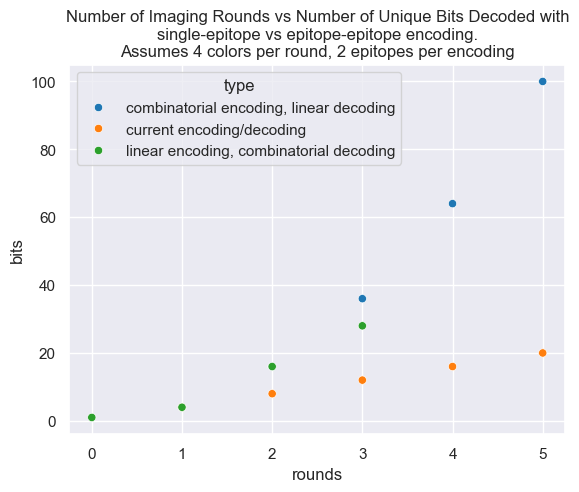

In [61]:
# plot the number of bits vs the number of imaging rounds

# max bits per round
grouped = df.groupby(["type", "rounds"]).max().reset_index().query("rounds <= 5")

sns.scatterplot(data=grouped, x="rounds", y="bits", hue="type")

# plt.legend()
# sns.despine()

# plt.axhline(y = 5, color = "red", linestyle = "--", linewidth = 1, label = "5 imaging rounds")
plt.title(
    f"Number of Imaging Rounds vs Number of Unique Bits Decoded with\nsingle-epitope vs epitope-epitope encoding.\nAssumes {colors_per_round} colors per round, 2 epitopes per encoding"
)
plt.show()
